In [15]:
import Pkg

#Pkg.add("Zygote")

using Zygote
using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
#using CUDA
using Statistics
using Plots

In [2]:
train_x, train_y = MNIST(split=:train)[:]
test_x, test_y = MNIST(split=:test)[:]

train_x = float.(train_x) ./ 255.0
test_x = float.(test_x) ./ 255.0

train_x = reshape(train_x, 28, 28, 1, :);
test_x = reshape(test_x, 28, 28, 1, :);

train_y = onehotbatch(train_y, 0:9);
test_y = onehotbatch(test_y, 0:9);


In [7]:
conv1 = Conv((3,3), 1=>16, relu)
pool1 = MaxPool((2,2))
conv2 = Conv((3,3), 16=>32, relu)
pool2 = MaxPool((2,2))
conv3 = Conv((3,3), 32=>64, relu)
pool3 = MaxPool((2,2))
flatten = Flux.flatten
dense1 = Dense(64, 128, relu)
dense2 = Dense(128, 10)
softmax_layer = softmax

model = Chain(conv1, pool1, conv2, pool2, conv3, pool3, flatten, dense1, dense2, softmax_layer)

loss(x,y) = crossentropy(model(x), y)
opt = ADAM()

Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8)

In [9]:
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    opt_state = Flux.setup(opt, model)  

    for epoch in 1:epochs
        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
            Flux.update!(opt_state, Flux.trainable(model), gs)  
        end
        println("Epoch $epoch complete")
    end
end


train_model! (generic function with 1 method)

In [10]:
train_model!(model, train_x, train_y, opt, 5, 64)

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete


In [12]:
#visualize_layers(model, train_x[:, :, :, 1:1])

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
println("Test Accuracy: ", accuracy(test_x, test_y))


Test Accuracy: 0.9519


In [139]:
function visualize_layer(input_data, layer, filter_labels)
    output = layer(input_data)  # Apply the convolutional layer

    num_filters = size(output, 4)  # Number of output channels

    # Create input plot
    input_plot = heatmap(input_data[:, :, 1, 1], color=:grays, axis=nothing, title="Input", xticks=false, yticks=false, colorbar = false)

    # Create output plots for each filter response with labels
    output_plots = [
        heatmap(output[:, :, 1, i], color=:viridis, axis=nothing, 
                title=string(filter_labels)
                , xticks=false, yticks=false, colorbar = false) 
        for i in 1:num_filters
    ]

    # Arrange plots in a grid (side by side)
    plot(input_plot, output_plots..., layout=(1, num_filters + 1))  # 1 row, num_filters + 1 columns
end


custom_filters = cat(
    [  
        [ 0  -1  0; -1  4 -1;  0  -1  0 ],
        [ 0  -1  0; -1  5 -1;  0  -1  0 ],
        [ 1   2  1;  0  0  0; -1  -2 -1 ],
        [ 1   0 -1;  2  0 -2;  1   0 -1 ],
        (1/16).*[ 1   2  1;  2  4  2;  1   2  1 ],
        [-2  -1  0; -1  1  1;  0   1  2 ]
    ]...,
    dims=3  # Stack along the third dimension (channels)
)

custom_filters = reshape(custom_filters, (3, 3, 1, 6))  # Reshape to (3, 3, 1, 5)


# Define filter labels corresponding to their function
filter_labels = [
    "Laplacian (Edge Detection)", 
    "Sharpening", 
    "Sobel (Vertical Edges)", 
    "Sobel (Horizontal Edges)", 
    "Gaussian Blur",
    "Embossing"
];



In [140]:
custom_filters

3×3×1×6 Array{Float64, 4}:
[:, :, 1, 1] =
  0.0  -1.0   0.0
 -1.0   4.0  -1.0
  0.0  -1.0   0.0

[:, :, 1, 2] =
  0.0  -1.0   0.0
 -1.0   5.0  -1.0
  0.0  -1.0   0.0

[:, :, 1, 3] =
  1.0   2.0   1.0
  0.0   0.0   0.0
 -1.0  -2.0  -1.0

[:, :, 1, 4] =
 1.0  0.0  -1.0
 2.0  0.0  -2.0
 1.0  0.0  -1.0

[:, :, 1, 5] =
 0.0625  0.125  0.0625
 0.125   0.25   0.125
 0.0625  0.125  0.0625

[:, :, 1, 6] =
 -2.0  -1.0  0.0
 -1.0   1.0  1.0
  0.0   1.0  2.0

In [150]:
conv_layer_1 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_1.weight .= custom_filters[1]  # Assign custom filters to the convolution layer

conv_layer_2 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_2.weight .= custom_filters[2]

conv_layer_3 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_3.weight .= custom_filters[3]

conv_layer_4 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_4.weight .= custom_filters[4]

conv_layer_5 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_5.weight .= custom_filters[5]

conv_layer_6 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_6.weight .= custom_filters[6]



LoadError: MethodError: no method matching Conv(::Tuple{Int64, Int64}, ::Int64, ::Int64, ::typeof(identity))
The type `Conv` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  Conv(::F, ::A, ::V, [91m::NTuple{N, Int64}[39m, [91m::NTuple{M, Int64}[39m, [91m::NTuple{N, Int64}[39m, [91m::Int64[39m) where {N, M, F, A, V}
[0m[90m   @[39m [35mFlux[39m [90m~/.julia/packages/Flux/3711C/src/layers/[39m[90m[4mconv.jl:140[24m[39m
[0m  Conv([91m::AbstractArray{T, N}[39m, ::Any, ::Any; stride, pad, dilation, groups) where {T, N}
[0m[90m   @[39m [35mFlux[39m [90m~/.julia/packages/Flux/3711C/src/layers/[39m[90m[4mconv.jl:149[24m[39m
[0m  Conv(::NTuple{N, Integer}, [91m::Pair{<:Integer, <:Integer}[39m, ::Any; init, stride, pad, dilation, groups, bias) where N
[0m[90m   @[39m [35mFlux[39m [90m~/.julia/packages/Flux/3711C/src/layers/[39m[90m[4mconv.jl:160[24m[39m
[0m  ...


In [156]:
input_data = train_x[:, :, :, 1:1];
blurred_data = conv_layer_5(input_data);

In [155]:
visualize_layer(blurred_data, conv_layer_1, filter_labels[1])

LoadError: DimensionMismatch: layer Conv((3, 3), 1 => 6) expects size(input, 3) == 1, but got 26×26×6×1 Array{Float32, 4}

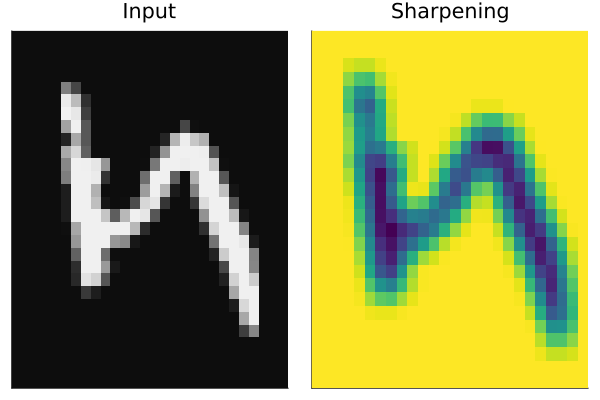

In [ ]:
visualize_layer(input_data, conv_layer_2, filter_labels[2])

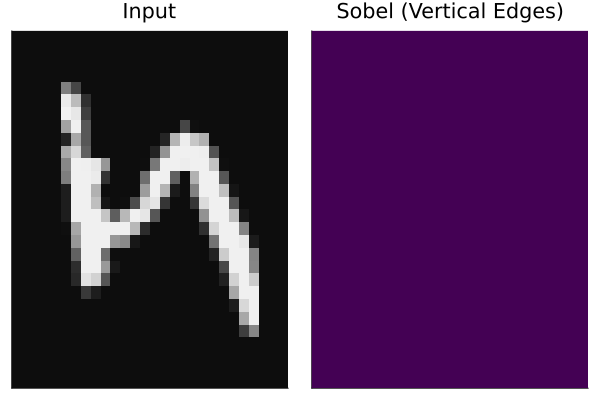

In [ ]:
visualize_layer(input_data, conv_layer_3, filter_labels[3])

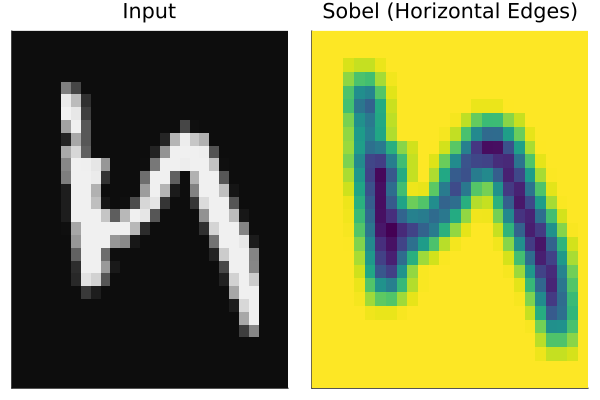

In [ ]:
visualize_layer(input_data, conv_layer_4, filter_labels[4])

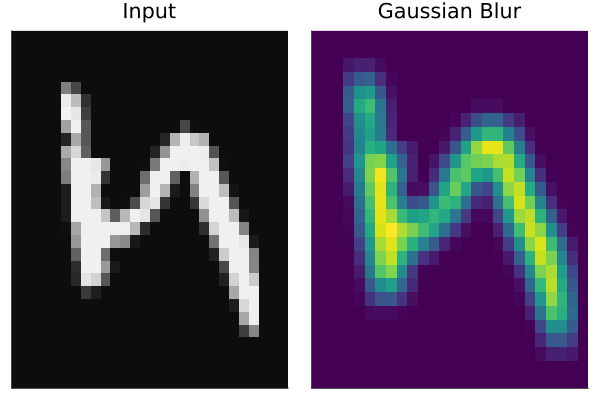

In [ ]:
visualize_layer(input_data, conv_layer_5, filter_labels[5])

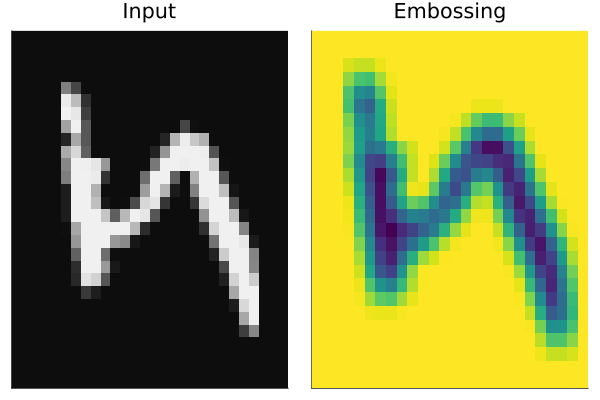

In [ ]:
visualize_layer(input_data, conv_layer_6, filter_labels[6])